In [8]:
import cv2

video = cv2.VideoCapture("C:/Users/srira/Downloads/v11.mp4")
background_subtractor = cv2.createBackgroundSubtractorMOG2()

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    foreground_mask = background_subtractor.apply(frame)
    contours, _ = cv2.findContours(foreground_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        if cv2.contourArea(contour) > 500:
            x, y, w, h = cv2.boundingRect(contour)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(frame, "Person Detected", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    cv2.imshow("Person Detection", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()


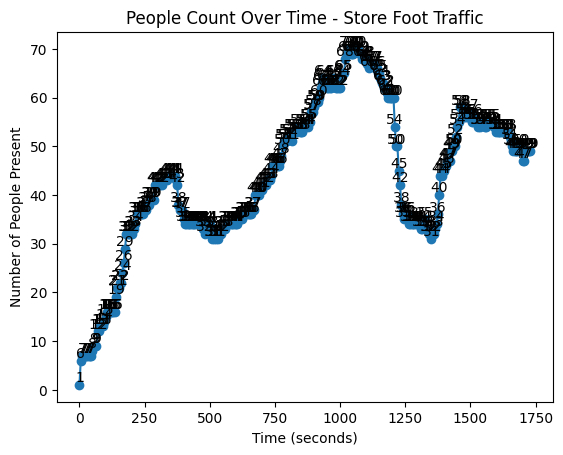

In [7]:
import cv2
import numpy as np
from scipy.spatial import distance as dist
from collections import OrderedDict
import matplotlib.pyplot as plt

class ObjectTracker:
    def __init__(self, max_missed=50):
        self.current_id = 0
        self.objects = OrderedDict()
        self.missed = OrderedDict()
        self.max_missed = max_missed

    def register(self, centroid):
        self.objects[self.current_id] = centroid
        self.missed[self.current_id] = 0
        self.current_id += 1

    def deregister(self, obj_id):
        del self.objects[obj_id]
        del self.missed[obj_id]

    def update(self, centroids):
        if len(centroids) == 0:
            for obj_id in list(self.missed.keys()):
                self.missed[obj_id] += 1
                if self.missed[obj_id] > self.max_missed:
                    self.deregister(obj_id)
            return self.objects

        if len(self.objects) == 0:
            for centroid in centroids:
                self.register(centroid)
        else:
            object_ids = list(self.objects.keys())
            object_centroids = list(self.objects.values())

            dist_matrix = dist.cdist(np.array(object_centroids), centroids)
            rows = dist_matrix.min(axis=1).argsort()
            cols = dist_matrix.argmin(axis=1)[rows]

            used_rows, used_cols = set(), set()

            for (row, col) in zip(rows, cols):
                if row in used_rows or col in used_cols:
                    continue
                obj_id = object_ids[row]
                self.objects[obj_id] = centroids[col]
                self.missed[obj_id] = 0

                used_rows.add(row)
                used_cols.add(col)

            unused_rows = set(range(0, dist_matrix.shape[0])).difference(used_rows)
            unused_cols = set(range(0, dist_matrix.shape[1])).difference(used_cols)

            for row in unused_rows:
                obj_id = object_ids[row]
                self.missed[obj_id] += 1
                if self.missed[obj_id] > self.max_missed:
                    self.deregister(obj_id)

            for col in unused_cols:
                self.register(centroids[col])

        return self.objects

video = cv2.VideoCapture("C:/Users/srira/Downloads/v2.1.mp4")
bg_subtractor = cv2.createBackgroundSubtractorMOG2()
tracker = ObjectTracker(max_missed=40)

frame_count = 0
people_counts = []

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    fg_mask = bg_subtractor.apply(frame)
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    centroids = []
    for contour in contours:
        if cv2.contourArea(contour) > 500:
            moments = cv2.moments(contour)
            cX = int(moments["m10"] / moments["m00"])
            cY = int(moments["m01"] / moments["m00"])
            centroids.append((cX, cY))

    objects = tracker.update(centroids)

    for (obj_id, centroid) in objects.items():
        text = f"ID {obj_id}"
        cv2.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv2.circle(frame, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)

    people_counts.append(len(objects))
    frame_count += 1

    cv2.putText(frame, f"People Count: {len(objects)}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    cv2.imshow("Tracking People", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

time_intervals = np.arange(0, len(people_counts) * 5, 5)  # Adjust for frame rate if necessary
plt.plot(time_intervals, people_counts, marker='o')
plt.xlabel("Time (seconds)")
plt.ylabel("Number of People Present")
plt.title("People Count Over Time - Store Foot Traffic")

for i, count in enumerate(people_counts):
    plt.text(time_intervals[i], count, str(count), ha='center', va='bottom')

plt.show()


In [6]:
import cv2

reference_image = cv2.imread("C:/Users/srira/Downloads/3.1.jpg", cv2.IMREAD_GRAYSCALE)
video = cv2.VideoCapture("C:/Users/srira/Downloads/v3.mp4")
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

orb = cv2.ORB_create()
keypoints_ref, descriptors_ref = orb.detectAndCompute(reference_image, None)

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        face_roi = gray_frame[y:y+h, x:x+w]
        keypoints_frame, descriptors_frame = orb.detectAndCompute(face_roi, None)

        if descriptors_frame is not None:
            bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
            matches = bf.match(descriptors_ref, descriptors_frame)

            if len(matches) > 10:
                cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
                cv2.putText(frame, "Match Found", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    cv2.imshow("Face Recognition", frame)
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()



In [5]:
import cv2

video = cv2.VideoCapture("C:/Users/srira/Downloads/v4.mp4")
bg_subtractor = cv2.createBackgroundSubtractorMOG2()

entry_count = 0
exit_count = 0

tracked_ids = set()

frame_count = 0
fps = video.get(cv2.CAP_PROP_FPS)

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    fg_mask = bg_subtractor.apply(frame)
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    current_frame_ids = set()

    for cnt in contours:
        if cv2.contourArea(cnt) > 500:
            x, y, w, h = cv2.boundingRect(cnt)
            center_x, center_y = x + w // 2, y + h // 2

            if center_x not in tracked_ids:
                entry_count += 1
                tracked_ids.add(center_x)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            else:
                exit_count += 1
                tracked_ids.remove(center_x)
                cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 0, 255), 2)

            current_frame_ids.add(center_x)

    for tracked_id in list(tracked_ids):
        if tracked_id not in current_frame_ids:
            tracked_ids.remove(tracked_id)

    cv2.putText(frame, f"Entry: {entry_count}, Exit: {exit_count}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

    cv2.imshow("People Counting", frame)
    frame_count += 1
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

print(f"Total entries: {entry_count}")
print(f"Total exits: {exit_count}")


Total entries: 824
Total exits: 247


In [4]:
import cv2
import time

video = cv2.VideoCapture("C:/Users/srira/Downloads/v4.mp4")

frame_count = 0
fps = video.get(cv2.CAP_PROP_FPS)
person_tracker = {}
unique_count = 0

person_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_fullbody.xml')

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detections = person_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    current_ids = set()
    for (x, y, w, h) in detections:
        person_id = f"{x}-{y}-{w}-{h}"

        if person_id not in person_tracker:
            person_tracker[person_id] = {'entry_time': frame_count / fps, 'exit_time': None}
            unique_count += 1
        else:
            person_tracker[person_id]['exit_time'] = frame_count / fps

        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, f"ID {unique_count}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        current_ids.add(person_id)

    for person_id in list(person_tracker.keys()):
        if person_id not in current_ids and person_tracker[person_id]['exit_time'] is None:
            person_tracker[person_id]['exit_time'] = frame_count / fps

    cv2.imshow('Video', frame)

    frame_count += 1

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

print(f"Unique persons detected: {unique_count}")
for person_id, times in person_tracker.items():
    entry = times['entry_time']
    exit_time = times['exit_time'] if times['exit_time'] is not None else frame_count / fps
    duration = exit_time - entry
    print(f"ID: {person_id} | Entry: {entry:.2f}s | Exit: {exit_time:.2f}s | Duration: {duration:.2f}s")


Unique persons detected: 60
ID: 1-123-31-63 | Entry: 6.17s | Exit: 6.21s | Duration: 0.03s
ID: 3-116-38-76 | Entry: 6.77s | Exit: 6.81s | Duration: 0.03s
ID: 4-112-40-81 | Entry: 7.04s | Exit: 7.07s | Duration: 0.03s
ID: 4-106-46-92 | Entry: 7.24s | Exit: 7.27s | Duration: 0.03s
ID: 4-103-47-95 | Entry: 7.27s | Exit: 7.31s | Duration: 0.03s
ID: 4-103-48-95 | Entry: 7.31s | Exit: 7.34s | Duration: 0.03s
ID: 4-105-46-92 | Entry: 7.34s | Exit: 7.37s | Duration: 0.03s
ID: 5-104-46-92 | Entry: 7.37s | Exit: 7.41s | Duration: 0.03s
ID: 4-100-48-97 | Entry: 7.41s | Exit: 7.44s | Duration: 0.03s
ID: 12-107-45-91 | Entry: 7.74s | Exit: 7.77s | Duration: 0.03s
ID: 13-113-42-85 | Entry: 7.91s | Exit: 7.94s | Duration: 0.03s
ID: 14-114-42-84 | Entry: 7.94s | Exit: 7.97s | Duration: 0.03s
ID: 13-110-45-90 | Entry: 7.97s | Exit: 8.01s | Duration: 0.03s
ID: 12-97-52-104 | Entry: 8.31s | Exit: 8.34s | Duration: 0.03s
ID: 16-111-45-90 | Entry: 8.34s | Exit: 8.37s | Duration: 0.03s
ID: 12-98-50-101 | En

In [3]:
import cv2

def track_objects(video_path):
    cap = cv2.VideoCapture(video_path)
    vehicle_counter = 0
    frame_width, frame_height = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        blurred_frame = cv2.GaussianBlur(gray_frame, (21, 21), 0)
        if 'background' not in locals():
            background = blurred_frame
            continue

        delta_frame = cv2.absdiff(background, blurred_frame)
        _, thresh_frame = cv2.threshold(delta_frame, 30, 255, cv2.THRESH_BINARY)

        contours, _ = cv2.findContours(thresh_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            area = cv2.contourArea(contour)
            if area > 500:
                vehicle_counter += 1

        cv2.imshow('Original', frame)
        cv2.imshow('Thresh', thresh_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    return vehicle_counter

video_path = "C:/Users/srira/Downloads/v2.mp4"
vehicles = track_objects(video_path)
print(f"Total vehicles detected: {vehicles}")


Total vehicles detected: 4460
